In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
def load_data(ticker):
    cache_dir = os.path.join('Database', '_cache', f"{ticker}-1d-5.csv")

    if os.path.exists(cache_dir):
        dir = cache_dir
    else:
        dir = os.path.join('Database', 'US', f"{ticker}-1d-5.csv")

    data = pd.read_csv(dir, index_col=0)
    data.index = pd.to_datetime(data.index, utc=True)
    data.index = data.index.tz_convert('US/Eastern')

    return data

def save_data(ticker, df):
    cache_dir = os.path.join('Database', '_cache', f"{ticker}-1d-5.csv")
    df.to_csv(cache_dir)

tickers = ['AAPL', 'CRM', '^GSPC']

def find_goodness_of_fit(series1, series2):
    corr = np.corrcoef(series1, series2)[0, 1]
    mse = np.mean((series1 - series2) ** 2)
    mape = np.mean(np.abs((series1 - series2) / series1))

    return corr, mse, mape

In [2]:
window = 22
data_holder = {}
for ticker in tickers:
    data_holder[ticker] = load_data(ticker)

# Calculate the daily returns
for ticker in tickers:
    data_holder[ticker]['daily_return'] = data_holder[ticker]['Close'].pct_change() * 100
    data_holder[ticker]['r_star'] = (data_holder[ticker]['daily_return'] - data_holder[ticker]['daily_return'].rolling(window=window).mean()) ** 2

# Historical Volatility Estimate

  Ticker  Correlation         MSE      MAPE
0   AAPL     0.231947   30.666328  1.103533
1    CRM     0.162665  123.387518  1.300825
2  ^GSPC     0.390337   39.942680  1.245528


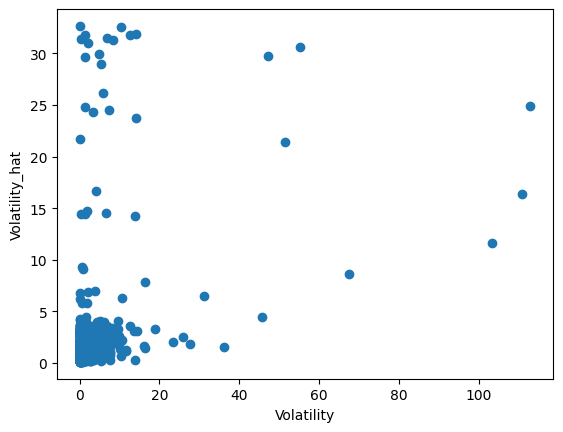

In [3]:
for ticker in tickers:

    data_holder[ticker]['h_vol_t'] = data_holder[ticker]['r_star'].rolling(window=window).mean()
    data_holder[ticker]['h_vol_t_hat'] = data_holder[ticker]['h_vol_t'].shift(1)

    data_holder[ticker] = data_holder[ticker].fillna(0)

    save_data(ticker, data_holder[ticker])

# Find the goodness of fit for all and print as a table
holder = []
for ticker in tickers:
    corr, mse, mape = find_goodness_of_fit(data_holder[ticker]['h_vol_t_hat'], data_holder[ticker]['r_star'])
    holder.append([ticker, corr, mse, mape])

df = pd.DataFrame(holder, columns=['Ticker', 'Correlation', 'MSE', 'MAPE'])
print(df)

# Plot the goodness of fit for CRM using scatter plot
plt.scatter(data_holder['^GSPC']['r_star'], data_holder['^GSPC']['h_vol_t_hat'])
plt.xlabel('Volatility')
plt.ylabel('Volatility_hat')
plt.show()

# Exponentially weighted moving average

  Ticker  Correlation         MSE      MAPE
0   AAPL     0.229247   30.710509  1.112249
1    CRM     0.164994  123.356042  1.361576
2  ^GSPC     0.472462   35.435286  1.161028


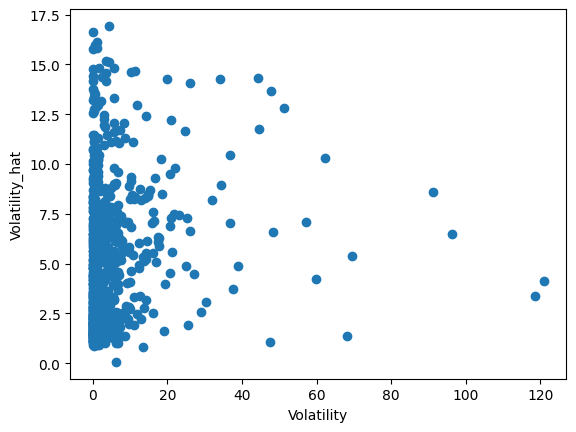

In [4]:
# Find the exponentially moving average of the volatility
for ticker in tickers:
    data_holder[ticker]['ew_vol_t'] = data_holder[ticker]['r_star'].ewm(span=window).mean()
    data_holder[ticker]['ew_vol_t_hat'] = data_holder[ticker]['ew_vol_t'].shift(1)
    
    # Dropna
    data_holder[ticker] = data_holder[ticker].fillna(0)

    save_data(ticker, data_holder[ticker])

# Find the goodness of fit for all and print as a table
holder = []
for ticker in tickers:
    corr, mse, mape = find_goodness_of_fit(data_holder[ticker]['ew_vol_t_hat'], data_holder[ticker]['r_star'])
    holder.append([ticker, corr, mse, mape])

df = pd.DataFrame(holder, columns=['Ticker', 'Correlation', 'MSE', 'MAPE'])
print(df)

# Plot the goodness of fit for CRM using scatter plot
plt.scatter(data_holder['CRM']['r_star'], data_holder['CRM']['ew_vol_t_hat'])
plt.xlabel('Volatility')
plt.ylabel('Volatility_hat')
plt.show()


# Estimate the volatility using GARCH

Handling  AAPL
Handling  CRM
Handling  ^GSPC
  Ticker  Correlation         MSE      MAPE
0   AAPL     0.128680   43.364096  1.362788
1    CRM     0.145029  148.142152  1.399314
2  ^GSPC     0.556032   35.665409  1.410424


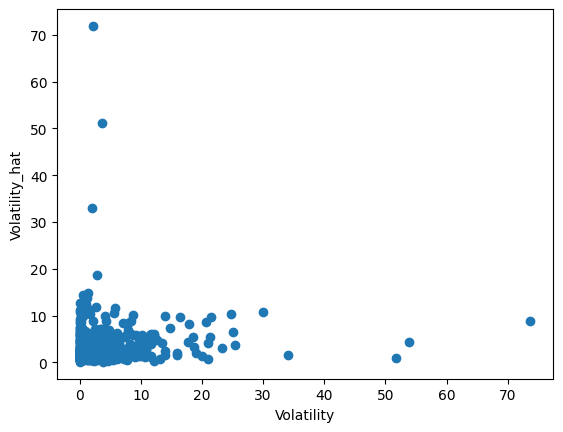

In [5]:
# Estimate volatility using GARCH
from arch import arch_model

for ticker in tickers:

    print ("Handling ", ticker)

    if 'garch_vol_t_hat' in data_holder[ticker]:
        continue

    tmp_holder = [None for i in range(window)]

    # Get the first 50 rows of the data_holder

    for i in range(window, len(data_holder[ticker])):

        print (f"{i}/{len(data_holder[ticker])}", end='\r')

        tmp = data_holder[ticker]['daily_return'].iloc[i-window:i]

        model = arch_model(tmp, vol='Garch', p=1, q=1, rescale=False)
        model_fit = model.fit(disp='off')

        # Print the conditional volatility
        vol_forecast = model_fit.forecast(horizon=1)
        tmp_holder.append(vol_forecast.variance.values[-1][0])

    data_holder[ticker]['garch_vol_t_hat'] = tmp_holder

    # Dropna
    data_holder[ticker] = data_holder[ticker].fillna()

    save_data(ticker, data_holder[ticker])

# Find the goodness of fit for all and print as a table
holder = []
for ticker in tickers:
    corr, mse, mape = find_goodness_of_fit(data_holder[ticker]['garch_vol_t_hat'], data_holder[ticker]['r_star'])
    holder.append([ticker, corr, mse, mape])

df = pd.DataFrame(holder, columns=['Ticker', 'Correlation', 'MSE', 'MAPE'])
print(df)


# Plot the goodness of fit for AAPL using scatter plot
plt.scatter(data_holder['AAPL']['r_star'], data_holder['AAPL']['garch_vol_t_hat'])
plt.xlabel('Volatility')
plt.ylabel('Volatility_hat')
plt.show()
    